In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn')

import requests
import io

from sklearn.preprocessing import MinMaxScaler as minmax
from sklearn.preprocessing import LabelEncoder

import tensorflow as tf


In [2]:
url="https://iaq-data.brgr.rocks/full.csv"
s=requests.get(url).content
data=pd.read_csv(io.StringIO(s.decode('utf-8')),parse_dates=['timestamp'],index_col='timestamp')

# data = pd.read_csv("nyc.csv",parse_dates=['Date'],index_col='Date')

In [3]:
train_cols = ["co2","livingroom_window_open","livingroom_door_open","balcony_door_open","kitchen_window_open"]
data = data[train_cols]

In [4]:
data.isna().sum()

co2                       0
livingroom_window_open    0
livingroom_door_open      0
balcony_door_open         0
kitchen_window_open       0
dtype: int64

In [5]:
data.dropna(inplace=True)

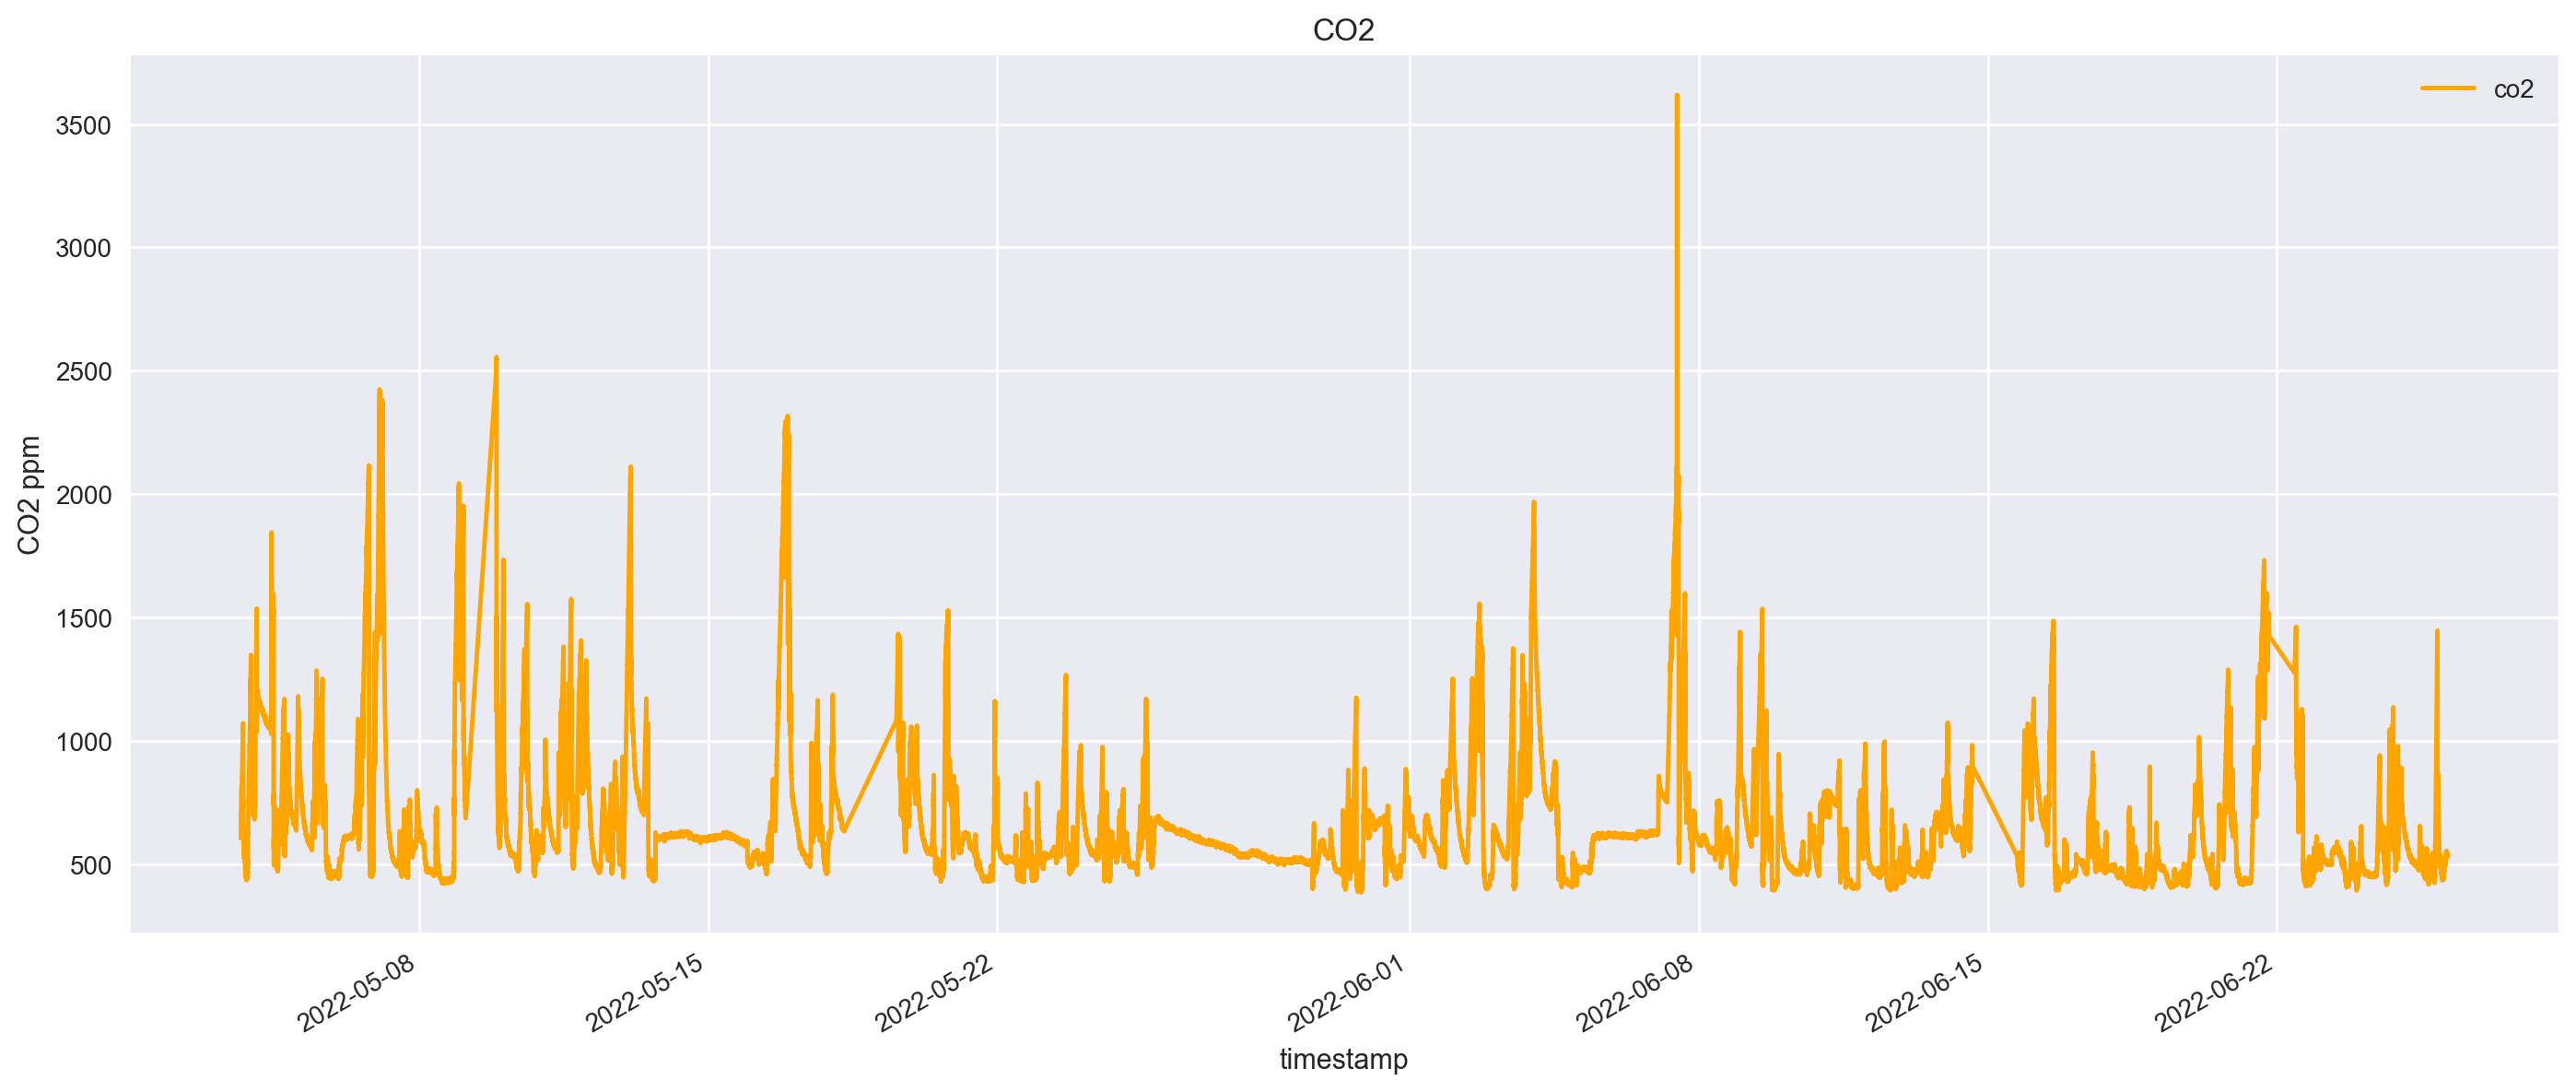

In [6]:
#Visualize our data

plt.figure(dpi=200,figsize=(17,7))
data["co2"].plot(legend=True,color='orange')
plt.title('CO2')
plt.ylabel("CO2 ppm")
plt.show()

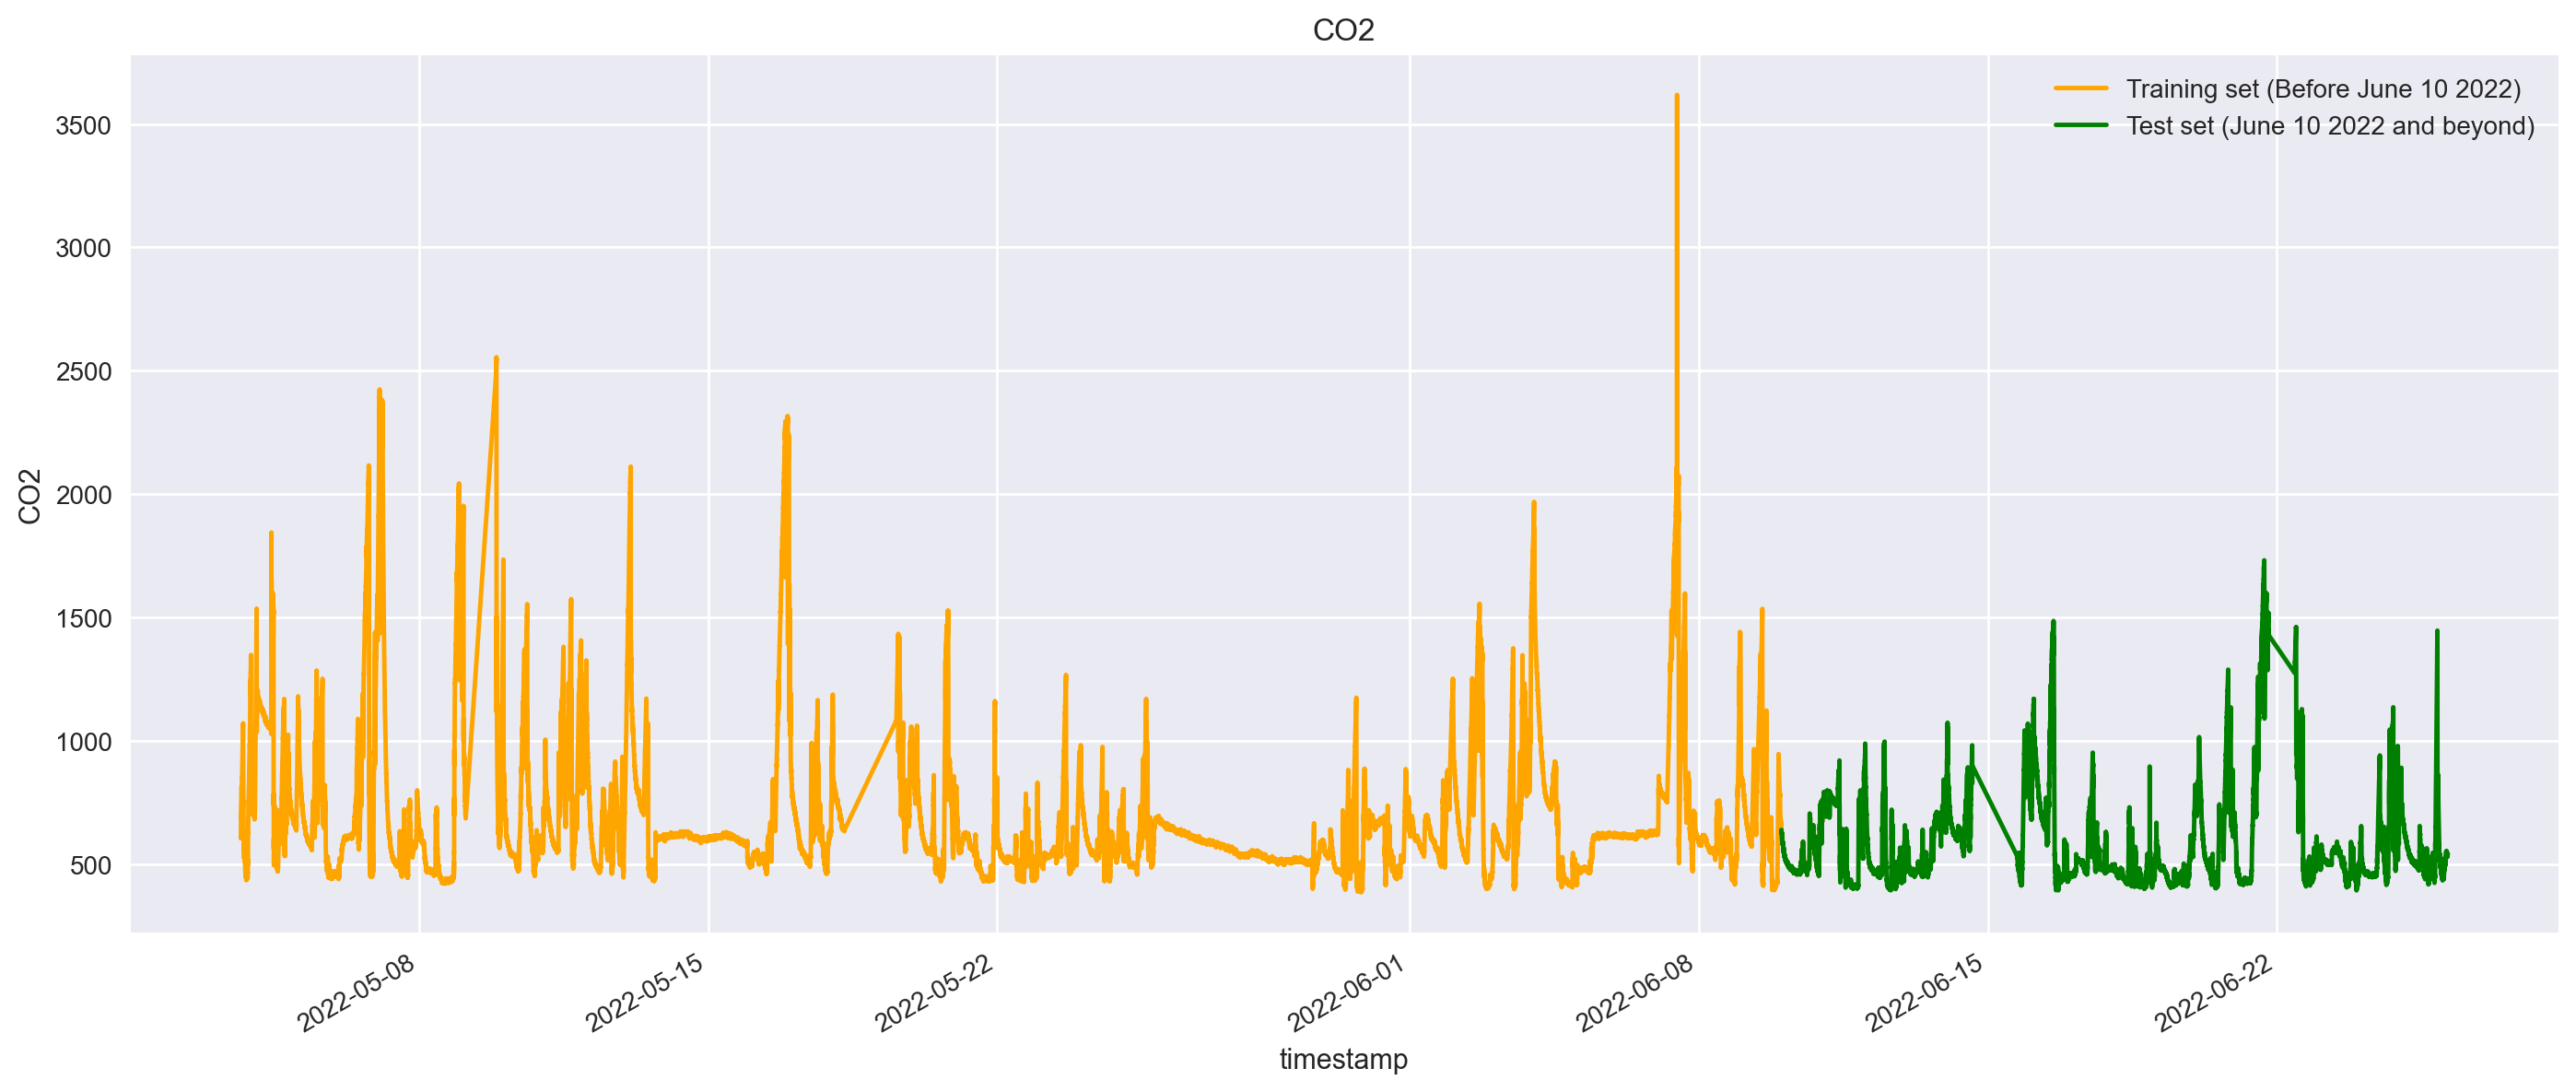

In [7]:
#Visualize our data - 2

plt.figure(dpi=200,figsize=(17,7))
data["co2"][:'2022-06-10'].plot(legend=True,color='orange')
data["co2"]['2022-06-10':].plot(legend=True,color='green')
plt.legend(['Training set (Before June 10 2022)','Test set (June 10 2022 and beyond)'])
plt.title('CO2')
plt.ylabel("CO2")
plt.show()

In [8]:
def make_dataset_many_to_many(array,time_steps):

    x = []
    y = []

    for i in range(time_steps,len(array)):
        x.append(array[i-time_steps:i])
        y.append(array[i])
        
    return np.array(x), np.array(y)

In [34]:
train = data[:"2022-06-10"].values
print(train.shape)

#scale values between 0 and 1
scaler = minmax(feature_range=(0,1))

train = scaler.fit_transform(train)

trn_x,trn_y = make_dataset_many_to_many(train,1)

(298181, 5)


## The three dimensions of this input are:

* **Samples**. One sequence is one sample. A batch is comprised of one or more samples.
* **Time Steps**. One time step is one point of observation in the sample.
* **Features**. One feature is one observation at a time step.

In [39]:
trn_x = trn_x.reshape(-1,20,1)
trn_y = trn_y.reshape(-1,20,1)

print(trn_x.shape,trn_y.shape)

(74545, 20, 1) (74545, 20, 1)


### Model Architecture

* LSTM(50)
* LSTM(50)
* Dense(500)
* Dropout(0.2)
* Dense(1)

In [40]:
model = tf.keras.models.Sequential()

model.add(tf.keras.layers.LSTM(50, return_sequences=True))
model.add(tf.keras.layers.LSTM(50, return_sequences=True))
model.add(tf.keras.layers.LSTM(50))

model.add(tf.keras.layers.Dense(500))

model.add(tf.keras.layers.Dropout(0.2))

model.add(tf.keras.layers.Dense(1))

early_stop = tf.keras.callbacks.EarlyStopping(monitor='mse', patience=15)
model.compile(optimizer='adam', loss='mse')

In [41]:
model.fit(trn_x, trn_y, epochs=2)

Epoch 1/2
2330/2330 [==============================] - 41s 16ms/step - loss: 0.1868
Epoch 2/2
2330/2330 [==============================] - 36s 15ms/step - loss: 0.1865


## Validation

* Test our model on whole data including test set

In [42]:
total = scaler.transform(data.values)
total_x,total_y = make_dataset_many_to_many(total,1)

In [43]:
print(total_x.shape)
predicted = model.predict(total_x)

(408283, 1, 5)


ValueError: in user code:

    File "c:\Users\lunar\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training.py", line 1845, in predict_function  *
        return step_function(self, iterator)
    File "c:\Users\lunar\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training.py", line 1834, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\lunar\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training.py", line 1823, in run_step  **
        outputs = model.predict_step(data)
    File "c:\Users\lunar\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training.py", line 1791, in predict_step
        return self(x, training=False)
    File "c:\Users\lunar\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\lunar\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\input_spec.py", line 264, in assert_input_compatibility
        raise ValueError(f'Input {input_index} of layer "{layer_name}" is '

    ValueError: Exception encountered when calling layer "sequential_2" (type Sequential).
    
    Input 0 of layer "lstm_6" is incompatible with the layer: expected shape=(None, None, 1), found shape=(None, 1, 5)
    
    Call arguments received by layer "sequential_2" (type Sequential):
      • inputs=tf.Tensor(shape=(None, 1, 5), dtype=float32)
      • training=False
      • mask=None


In [47]:
predicted = scaler.inverse_transform(predicted)

In [48]:
#make a dataset with real and predicted values.

infered = pd.DataFrame(data.iloc[2:])
infered['co2_predicted'] = predicted[:,0]

In [49]:
infered.tail()

,co2,livingroom_window_open,co2_predicted
timestamp,,,
2022-06-24 03:59:47.699000+00:00,460.68,False,446.807922
2022-06-24 03:59:58.280000+00:00,461.16,False,445.923279
2022-06-24 04:00:08.797000+00:00,462.56,False,445.396576
2022-06-24 04:00:19.297000+00:00,463.18,False,446.204620
2022-06-24 04:00:29.823000+00:00,463.76,False,447.317261


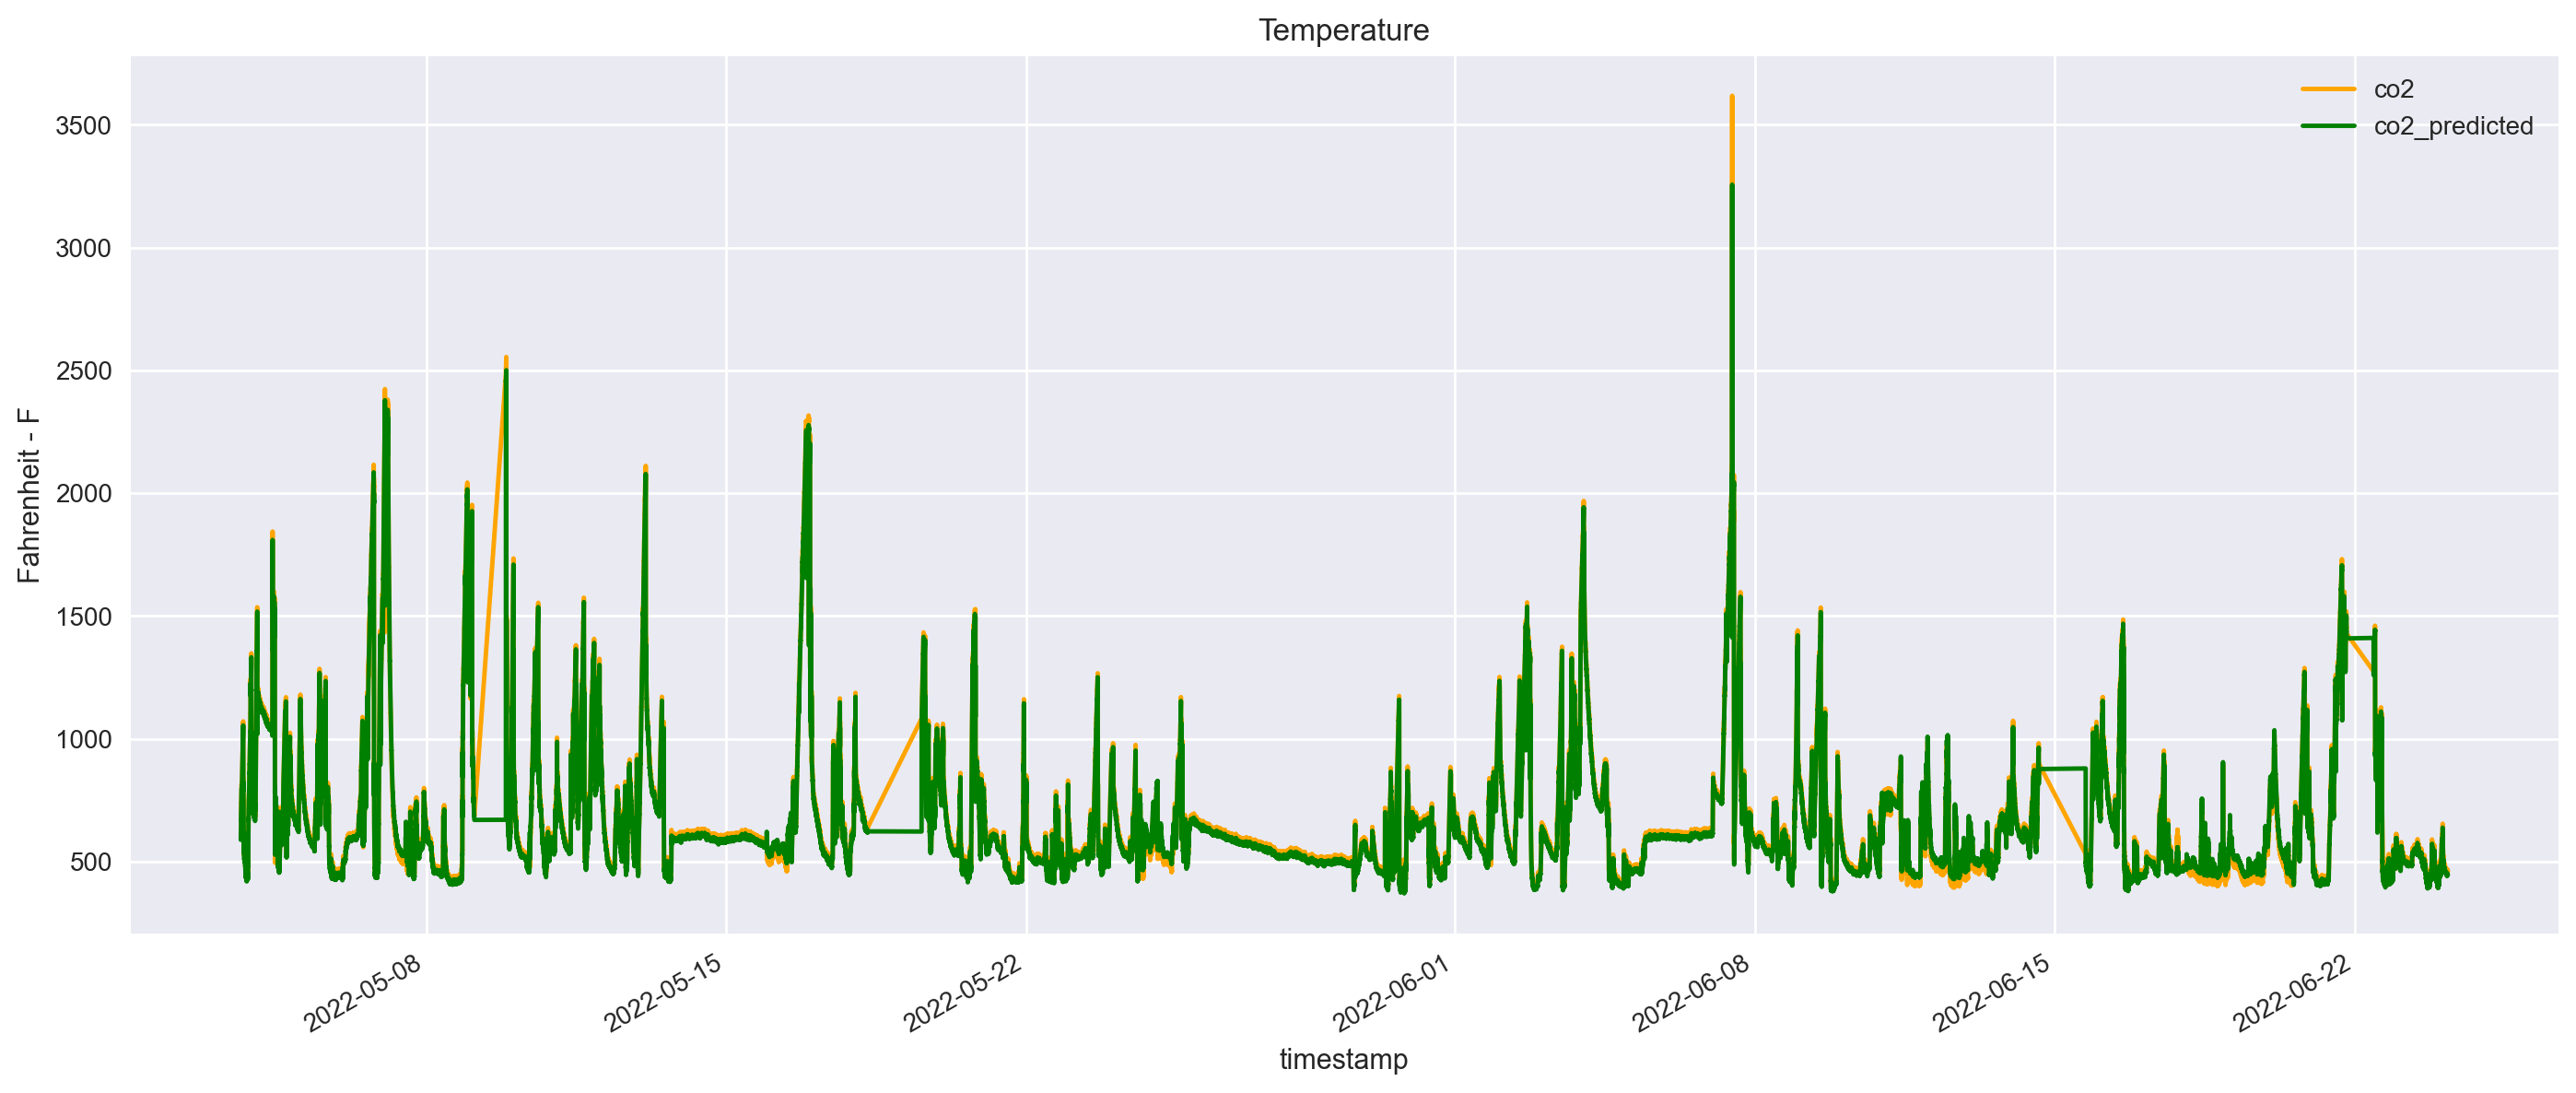

In [50]:
plt.figure(dpi=200,figsize=(17,7))
infered["co2"].plot(legend=True,color='orange')
infered["co2_predicted"].plot(legend=True,color='green')
plt.title('Temperature')
plt.ylabel("Fahrenheit - F")
plt.show()

## Testset visualization

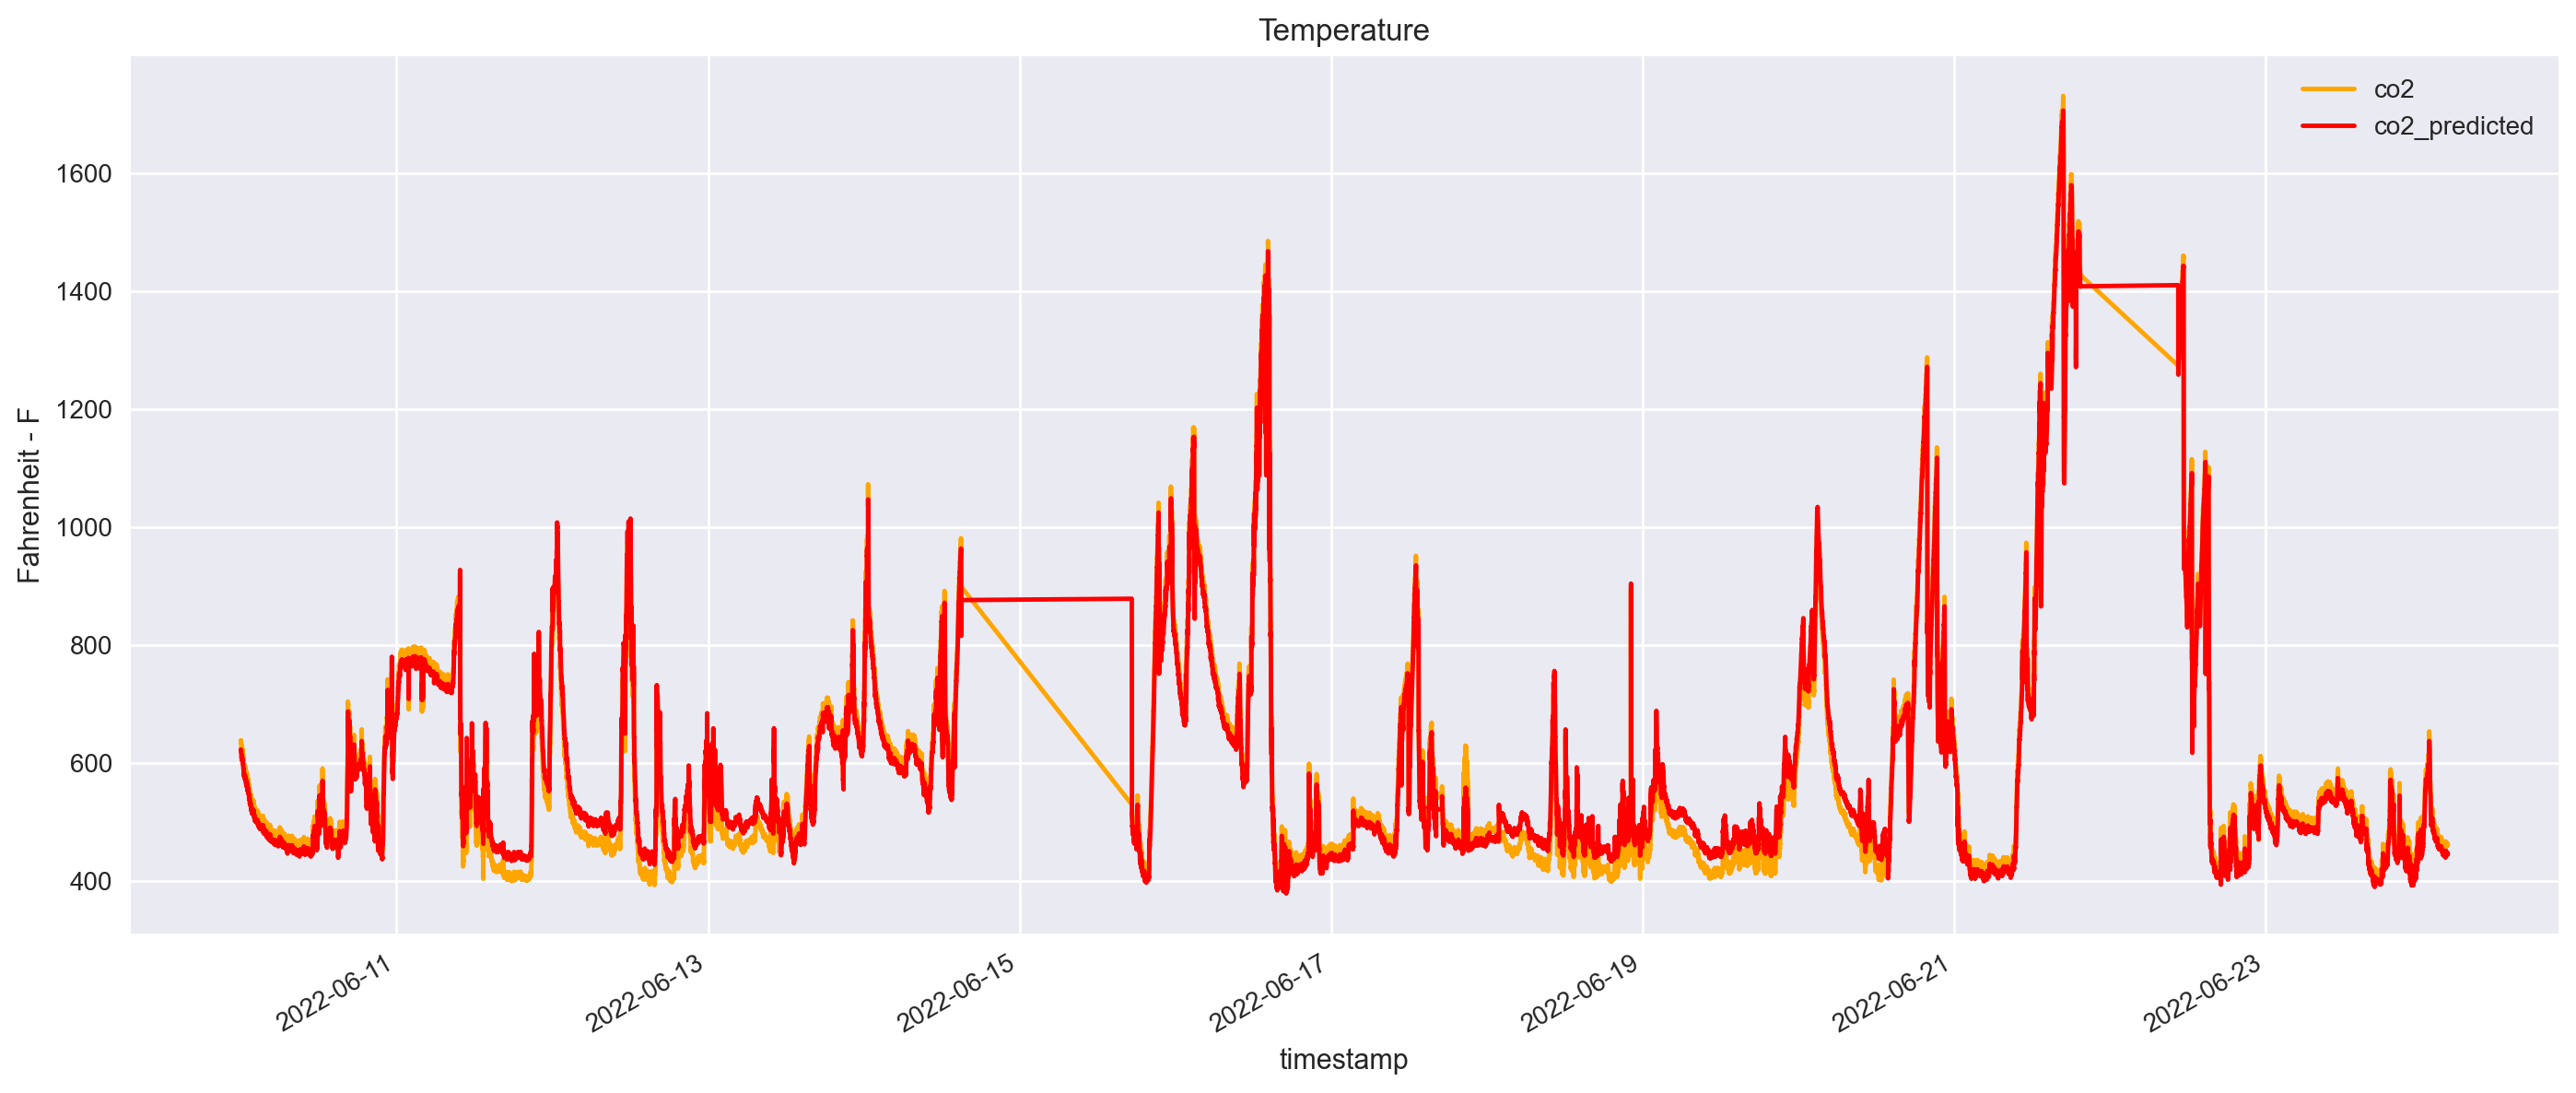

In [52]:
plt.figure(dpi=200,figsize=(17,7))
infered["2022-06-10":]["co2"].plot(legend=True,color='orange')
infered["2022-06-10":]["co2_predicted"].plot(legend=True,color='red')
plt.title('Temperature')
plt.ylabel("Fahrenheit - F")
plt.show()

In [51]:
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(infered[["co2"]],infered[["co2_predicted"]])
print("RMSE:", np.sqrt(mse))

RMSE: 21.156849101033014


In [27]:
#save model

model.save("model")